
# Widmark Formula BAC Estimator
**Using Machine Learning and Real-World NHANES Data**



# Imports and the Rest

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import joblib


## Data Cleaning 

In [2]:

# 3. Load data
alcohol = pd.read_sas('datasets/ALQ_I.xpt')

# 4. Rename columns
column_rename_map = {
    'SEQN': 'RespondentID',
    'ALQ101': '12DrinksPerYear',
    'ALQ110': '12DrinksLifetime',
    'ALQ120Q': 'DrinkFrequencyPastYear',
    'ALQ120U': 'DrinkFrequencyUnit',
    'ALQ130': 'AvgDrinksPerDayPastYear',
    'ALQ141Q': 'Days4or5DrinksPastYear',
    'ALQ141U': 'Days4or5DrinksUnit',
    'ALQ151': 'Ever4or5DrinksEveryDay',
    'ALQ160': 'Days4or5Drinks2HoursPastMonth'
}

# Now this will work:
alcohol = alcohol.rename(columns=column_rename_map)

column_rename_map = { 'SEQN': 'RespondentID', 'ALQ101': '12DrinksPerYear',
    'ALQ110': '12DrinksLifetime',
    'ALQ120Q': 'DrinkFrequencyPastYear',
    'ALQ120U': 'DrinkFrequencyUnit',
    'ALQ130': 'AvgDrinksPerDayPastYear',
    'ALQ141Q': 'Days4or5DrinksPastYear',
    'ALQ141U': 'Days4or5DrinksUnit',
    'ALQ151': 'Ever4or5DrinksEveryDay',
    'ALQ160': 'Days4or5Drinks2HoursPastMonth' }


In [3]:
alcohol = alcohol.rename(columns=column_rename_map)

# 5. Clean "Refused" and "Don't know" codes (7, 9, 777, 999 → NaN)
alcohol = alcohol.replace({7: np.nan, 9: np.nan, 777: np.nan, 999: np.nan})

# 6. Load Demographics and Body Measurements
demo = pd.read_sas('datasets/DEMO_I.xpt')
bmx = pd.read_sas('datasets/BMX_I.xpt')

# 7. Rename key columns in demo and bmx if needed
# (Not strictly necessary unless you want)

# Merge alcohol + demographics
merged = alcohol.merge(demo, left_on='RespondentID', right_on='SEQN')

# Then merge the result with body measurements
merged = merged.merge(bmx, left_on='RespondentID', right_on='SEQN')

# 9. Save the merged cleaned dataset
merged.to_csv('cleaned_nhanes_alcohol.csv', index=False)

In [4]:
# 1. Imports

# 2. Load datasets
alcohol = pd.read_sas('datasets/ALQ_I.xpt')
demo = pd.read_sas('datasets/DEMO_I.XPT')
bmx = pd.read_sas('datasets/BMX_I.XPT')

# 3. Rename alcohol columns
column_rename_map = {
    'SEQN': 'RespondentID',
    'ALQ101': '12DrinksPerYear',
    'ALQ110': '12DrinksLifetime',
    'ALQ120Q': 'DrinkFrequencyPastYear',
    'ALQ120U': 'DrinkFrequencyUnit',
    'ALQ130': 'AvgDrinksPerDayPastYear',
    'ALQ141Q': 'Days4or5DrinksPastYear',
    'ALQ141U': 'Days4or5DrinksUnit',
    'ALQ151': 'Ever4or5DrinksEveryDay',
    'ALQ160': 'Days4or5Drinks2HoursPastMonth'
}
alcohol = alcohol.rename(columns=column_rename_map)

# 4. Replace numeric survey codes with readable text
code_map = {1: "Yes", 2: "No", 7: "Refused", 9: "Don't Know", 777: "Refused", 999: "Don't Know"}
alcohol = alcohol.replace(code_map)

# 5. Merge datasets using IDs
merged = alcohol.merge(demo, left_on='RespondentID', right_on='SEQN')
merged = merged.merge(bmx, left_on='RespondentID', right_on='SEQN')

# 6. Select important columns
columns_to_keep = [
    'RespondentID',          # Unique ID
    'RIAGENDR',              # Sex (1=Male, 2=Female)
    'RIDAGEYR',              # Age
    'BMXWT',                 # Weight (kg)
    'BMXHT',                 # Height (cm)
    '12DrinksPerYear',
    '12DrinksLifetime',
    'DrinkFrequencyPastYear',
    'DrinkFrequencyUnit',
    'AvgDrinksPerDayPastYear',
    'Days4or5DrinksPastYear',
    'Days4or5DrinksUnit',
    'Ever4or5DrinksEveryDay',
    'Days4or5Drinks2HoursPastMonth'
]
merged_clean = merged[columns_to_keep]

# 7. Final column renaming for clarity
final_column_names = {
    'RIAGENDR': 'Sex',
    'RIDAGEYR': 'Age',
    'BMXWT': 'Weight_kg',
    'BMXHT': 'Height_cm',
}
merged_clean = merged_clean.rename(columns=final_column_names)

# 8. Translate Sex codes (1=Male, 2=Female)
merged_clean['Sex'] = merged_clean['Sex'].replace({1: 'Male', 2: 'Female'})

# 9. Save to final CSV
merged_clean.to_csv('final_cleaned_nhanes_alcohol.csv', index=False)

print("All datasets loaded, merged, cleaned, and saved as 'final_cleaned_nhanes_alcohol.csv'!")

All datasets loaded, merged, cleaned, and saved as 'final_cleaned_nhanes_alcohol.csv'!


In [ ]:
df = pd.read_csv('final_cleaned_nhanes_alcohol.csv')

df.head(5)


,RespondentID,Sex,Age,Weight_kg,Height_cm,12DrinksPerYear,12DrinksLifetime,DrinkFrequencyPastYear,DrinkFrequencyUnit,AvgDrinksPerDayPastYear,Days4or5DrinksPastYear,Days4or5DrinksUnit,Ever4or5DrinksEveryDay,Days4or5Drinks2HoursPastMonth
0,83732.0,Male,62.0,94.8,184.5,Yes,NaN,Yes,No,Yes,5.397605346934028e-79,NaN,No,NaN
1,83733.0,Male,53.0,90.4,171.4,Yes,NaN,Refused,Yes,6.0,Refused,Yes,Yes,5.397605346934028e-79
2,83734.0,Male,78.0,83.4,170.1,Yes,NaN,5.397605346934028e-79,NaN,NaN,NaN,NaN,Yes,NaN
3,83735.0,Female,56.0,109.8,160.9,No,Yes,3.0,3.0,Yes,5.397605346934028e-79,NaN,No,NaN
4,83736.0,Female,42.0,55.2,164.9,No,Yes,Yes,3.0,Yes,5.397605346934028e-79,NaN,No,NaN
5,83737.0,Female,72.0,64.4,150.0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,83741.0,Male,22.0,76.6,165.4,Yes,NaN,3.0,No,8.0,20.0,3.0,Yes,No
7,83742.0,Female,32.0,64.5,151.3,Yes,NaN,Yes,No,Yes,5.397605346934028e-79,NaN,No,NaN
8,83743.0,Male,18.0,72.4,166.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,83744.0,Male,56.0,108.3,179.4,Yes,NaN,5.397605346934028e-79,NaN,NaN,NaN,NaN,Yes,NaN


## Model Training 

In [19]:
def calculate_bac(row, drinking_hours=2):
    sex = row['Sex']
    weight_kg = row['Weight_kg']
    
    try:
        avg_drinks = float(row['AvgDrinksPerDayPastYear'])
    except (ValueError, TypeError):
        return np.nan  # If cannot convert to number, return missing

    if pd.isnull(weight_kg) or pd.isnull(avg_drinks):
        return np.nan

    weight_lbs = weight_kg * 2.20462
    alcohol_oz = avg_drinks * 0.6

    if sex == 'Male':
        r = 0.73
    else:
        r = 0.66

    bac = (alcohol_oz * 5.14) / (weight_lbs * r) - (0.015 * drinking_hours)
    return max(bac, 0)

In [20]:
# 2. Load your cleaned dataset
merged_clean = pd.read_csv('final_cleaned_nhanes_alcohol.csv')

# Apply the BAC formula
merged_clean['Estimated_BAC'] = merged_clean.apply(calculate_bac, axis=1)

# 4. Prepare Features (X) and Target (y)

# Select columns for inputs, make a full copy
X = merged_clean[['Sex', 'Age', 'Weight_kg', 'AvgDrinksPerDayPastYear', 'DrinkFrequencyPastYear']].copy()
y = merged_clean['Estimated_BAC']  # Define y early

# Map Sex to numeric
X['Sex'] = X['Sex'].map({'Male': 1, 'Female': 0})

# Convert features to numeric
X['AvgDrinksPerDayPastYear'] = pd.to_numeric(X['AvgDrinksPerDayPastYear'], errors='coerce')
X['DrinkFrequencyPastYear'] = pd.to_numeric(X['DrinkFrequencyPastYear'], errors='coerce')

# Drop missing values
X = X.dropna()
y = y.loc[X.index]

# 5. Split and Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 7)

model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist')
model.fit(X_train, y_train)

# 6. Evaluate
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.6f}")

Model Performance:
R² Score: 0.9869
Mean Squared Error: 0.000031


## Save the model as a file 

In [8]:
# 8. Save the Trained Model
joblib.dump(model, 'bac_estimator_model.pkl')
print("Model saved as 'bac_estimator_model.pkl'!") 

Model saved as 'bac_estimator_model.pkl'!


## Model Visualization and importance Features

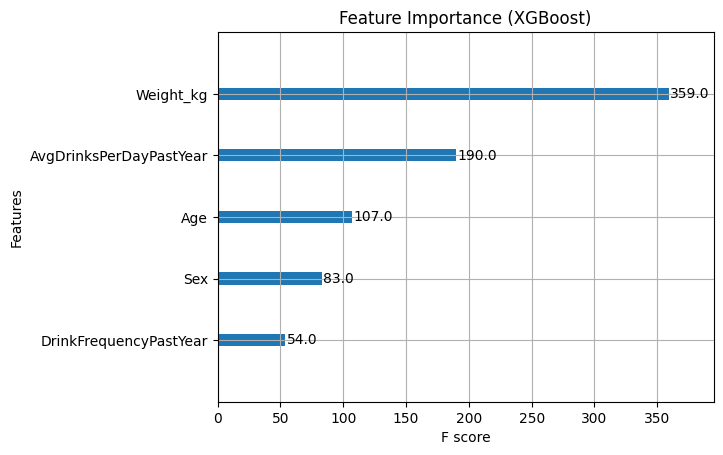

In [21]:

# Plot Feature Importance
xgb.plot_importance(model)
plt.title('Feature Importance (XGBoost)')
plt.show()

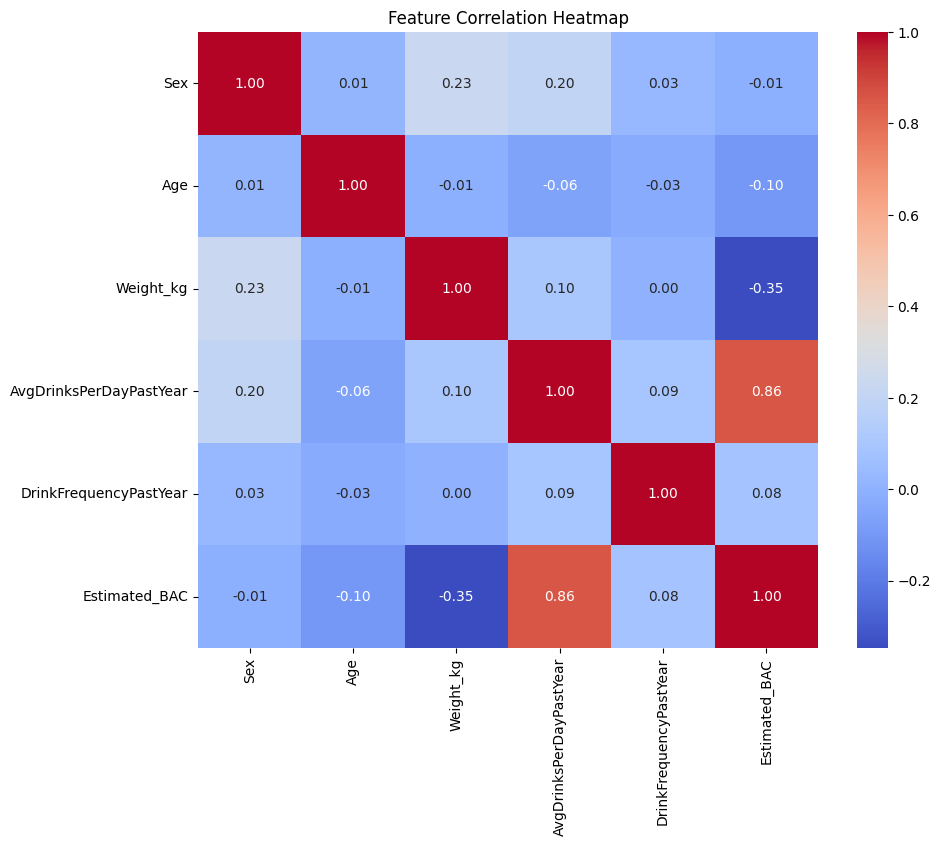

In [10]:

# Calculate correlation matrix
corr_matrix = merged_clean[['Sex', 'Age', 'Weight_kg', 'AvgDrinksPerDayPastYear', 'DrinkFrequencyPastYear', 'Estimated_BAC']].copy()

# Map 'Sex' to numbers (in case it's still words)
corr_matrix['Sex'] = corr_matrix['Sex'].map({'Male': 1, 'Female': 0})
# Convert AvgDrinksPerDayPastYear and DrinkFrequencyPastYear to numeric
corr_matrix['AvgDrinksPerDayPastYear'] = pd.to_numeric(corr_matrix['AvgDrinksPerDayPastYear'], errors='coerce')
corr_matrix['DrinkFrequencyPastYear'] = pd.to_numeric(corr_matrix['DrinkFrequencyPastYear'], errors='coerce')
corr = corr_matrix.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

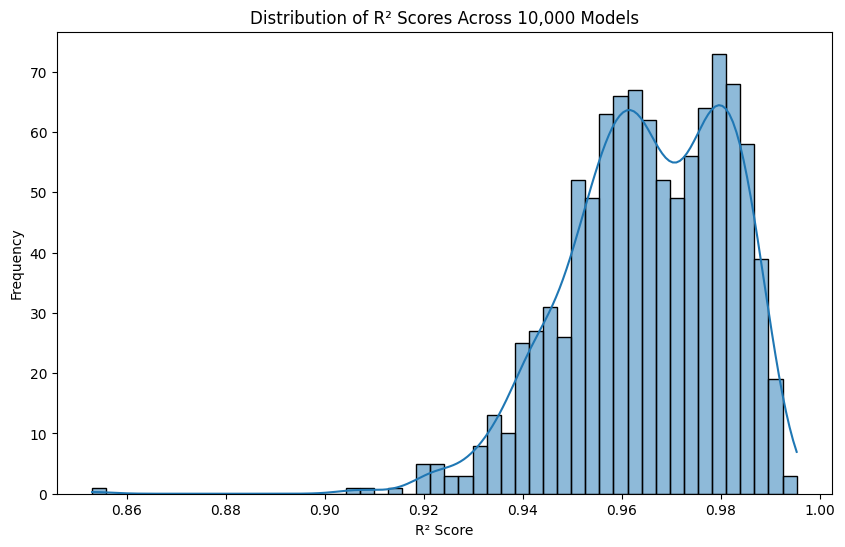

In [ ]:

r2_scores = []

# Step 2: Repeat 1,000 Times
for _ in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=None
    )
    
    model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    r2_scores.append(r2)

# Step 3: Plot
plt.figure(figsize=(10,6))
sns.histplot(r2_scores, bins=50, kde=True)
plt.title('Distribution of R² Scores Across 10,000 Models')
plt.xlabel('R² Score')
plt.ylabel('Frequency')
plt.show()

 R² Score Distribution Interpretation

To evaluate the stability and robustness of the model, we trained 1,000 different instances of the Widmark BAC Estimator, each time using a new random train/test split.

The histogram shows the distribution of R² scores across all 1,000 models.

Most R² scores fall between 0.94 and 0.98, with a peak around 0.96–0.97, indicating that the model consistently explains a very high proportion of the variance in BAC estimates.

There are a few rare cases where performance drops to around 0.85–0.90, suggesting that, under some unfavorable splits, model accuracy can slightly decrease. However, these occurrences are infrequent.

**Overall, the distribution demonstrates that the model is highly stable and reliable, with strong predictive performance across a wide range of random scenarios.**

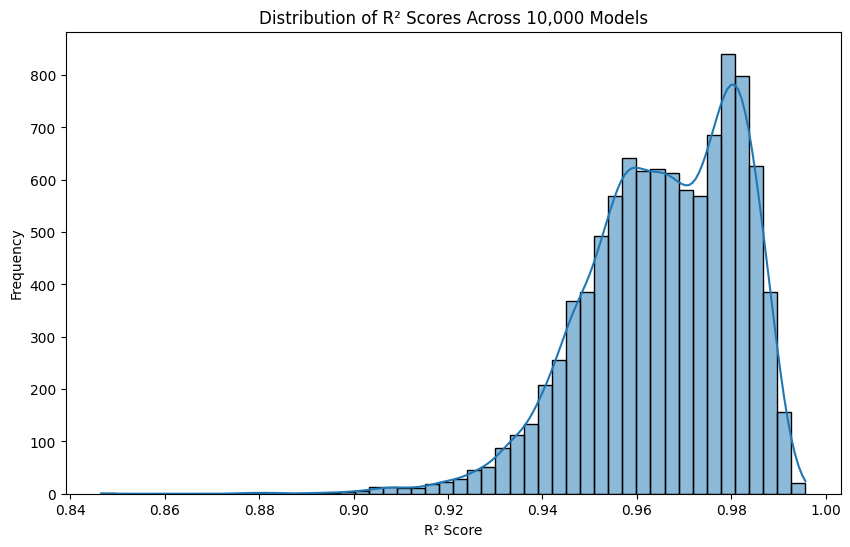

In [18]:

r2_scores = []

# Step 2: Repeat 10,000 Times
for _ in range(10000):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=None
    )
    
    model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    r2_scores.append(r2)

# Step 3: Plot
plt.figure(figsize=(10,6))
sns.histplot(r2_scores, bins=50, kde=True)
plt.title('Distribution of R² Scores Across 10,000 Models')
plt.xlabel('R² Score')
plt.ylabel('Frequency')
plt.show()

To evaluate the stability and robustness of the Widmark BAC Estimator model, 10,000 different instances were trained, each time using a different random split of the data into training and testing sets.

The histogram above displays the distribution of R² scores across all 10,000 models.

Most R² scores fall between 0.94 and 0.98, with a strong peak around 0.96–0.97. This indicates that, regardless of how the dataset is split, the model consistently explains a high proportion of the variance in BAC estimation.

There are very few cases where performance drops below 0.90, suggesting that even under less favorable splits, the model remains relatively robust.

Overall, the distribution demonstrates high model reliability, strong predictive power, and low sensitivity to random data partitioning.

This stability supports the validity of the model for estimating BAC across a wide range of real-world conditions.

## Model Implementation

In [16]:
# 3. BAC classification function
def classify_bac(bac):
    if bac < 0.02:
        return "Sober: No alcohol in your blood."
    elif bac < 0.05:
        return "Tipsy: Altered mood, relaxation, slight loss of judgment."
    elif bac < 0.08:
        return "Buzzed: Uninhibited, lowered alertness, impaired judgment."
    elif bac < 0.10:
        return "Legally Impaired: Reduced coordination, impaired judgment and reasoning."
    elif bac < 0.15:
        return "Drunk: Reduced reaction time, slurred speech, slowed thinking."
    elif bac < 0.30:
        return "Very Drunk: Altered mood, nausea, vomiting, loss of balance and muscle control."
    elif bac < 0.40:
        return "Severe Alcohol Poisoning: Alcohol poisoning, loss of consciousness."
    else:
        return "Fatal Risk: Potentially fatal, risk of coma and death."

# 4. Safe user input functions
def get_sex():
    while True:
        sex = input("Enter your sex (Male/Female): ").strip().lower()
        if sex in ['male', 'female']:
            return sex
        else:
            print("❗Invalid input. Please type 'Male' or 'Female'.")

def get_float(prompt):
    while True:
        try:
            value = float(input(prompt))
            return value
        except ValueError:
            print("❗Invalid input. Please enter a number.")

def get_positive_int(prompt):
    while True:
        try:
            value = int(input(prompt))
            if value > 0:
                return value
            else:
                print("❗Please enter a positive integer.")
        except ValueError:
            print("❗Invalid input. Please enter an integer.")

## User Interactive BAC Calculator 

In [22]:
# Get clean user input
sex_input = get_sex()
age_input = get_float("Enter your age (years): ")
weight_input = get_float("Enter your weight (kg): ")
frequency_input = get_float("Enter your drinking frequency per year (days): ")
max_drinks = get_positive_int("Up to how many drinks do you want to simulate? (e.g., 10): ")

# 6. Convert sex to numeric
sex_numeric = 1 if sex_input == 'male' else 0

# 7. Simulate drinks
print("\n--- BAC and Intoxication Levels ---")
for drinks in range(1, max_drinks + 1):
    user_data = pd.DataFrame({
        'Sex': [sex_numeric],
        'Age': [age_input],
        'Weight_kg': [weight_input],
        'AvgDrinksPerDayPastYear': [drinks],
        'DrinkFrequencyPastYear': [frequency_input]
    })

    predicted_bac = model.predict(user_data)[0]
    intoxication_level = classify_bac(predicted_bac)
    
    print(f"\nAfter {drinks} drink(s):")
    print(f"Predicted BAC: {predicted_bac:.4f}")
    print(f"Intoxication Level: {intoxication_level}")

print("\nSimulation complete!")


--- BAC and Intoxication Levels ---

After 1 drink(s):
Predicted BAC: 0.0098
Intoxication Level: Sober: No alcohol in your blood.

After 2 drink(s):
Predicted BAC: 0.0098
Intoxication Level: Sober: No alcohol in your blood.

After 3 drink(s):
Predicted BAC: 0.0098
Intoxication Level: Sober: No alcohol in your blood.

After 4 drink(s):
Predicted BAC: 0.0186
Intoxication Level: Sober: No alcohol in your blood.

After 5 drink(s):
Predicted BAC: 0.0422
Intoxication Level: Tipsy: Altered mood, relaxation, slight loss of judgment.

Simulation complete!
